Copyright 2020-2022 Universidad Complutense de Madrid

This file software has been employed to calibrate optical spectroscopic data from the OSIRIS instrument at GTC (see [Paliya et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...903L...8P/abstract))

Authors: Cristina Cabello (criscabe@ucm.es), Nicolás Cardiel (cardiel@ucm.es) Jesús Gallego (j.gallego@ucm.es)

SPDX-License-Identifier: GPL-3.0+ License-Filename: LICENSE.txt

In [63]:
plotwidth = 12  # 10 for widget, 12 otherwise
#%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 17.0
mpl.rcParams['font.family'] = 'serif'
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.stats import mad_std, sigma_clipped_stats
from dust_extinction.parameter_averages import F99
import numpy as np
import pandas as pd
from photutils import aperture_photometry
from photutils import CircularAperture, CircularAnnulus
from photutils import DAOStarFinder
from scipy.signal import medfilt
from synphot import Observation, SourceSpectrum, SpectralElement
from synphot import units
from synphot.models import Empirical1D
#import stsynphot as stsyn

from numina.array.display.ximshow import jimshow
from numina.array.stats import robust_std

from der_snr import der_snr

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

# <span style="color:red">Calibrating the OSIRIS spectrum of the J1219 object</span>  

### In this notebook, we carry out:
### - The flux calibration
### - The telluric correction
### - The flux correction due to light losses
### - The Galactic extinction correction
### - S/N estimation and comparison with SLOAN spectrum

----------------------------------------------------------------------------

##  <span style="color:blue"> ---> FLUX CALIBRATION and TELLURIC CORRECTION</span> 

The spectroscopic data of J1219 were composed of two Observing Blocks (OBs) which contain three individual exposures of 1200 s each. Thus, the total exposure on-source was 7200 s.

First, we corrected the spatial offset between the 2D images of the two OBs, combined the images, and extracted the 1D spectrum of J1219.

In [64]:
# read reduced 2D images

with fits.open('b1_2_uwssa.fits') as hdul:
    header1 = hdul[0].header
    ob1data = hdul[0].data

with fits.open('b2_1_uwssa.fits') as hdul:
    header2 = hdul[0].header
    ob2data = hdul[0].data


naxis1 = header1['naxis1']
naxis2 = header1['naxis2']
crpix1 = header1['crpix1']
crval1 = header1['crval1']
cdelt1 = header1['cdelt1']
ctype1 = 'wavelength'

wave = crval1 + (np.arange(naxis1) + 1 - crpix1) * cdelt1

In [65]:
# shift first image 51 pixels upwards
ob1temp = np.zeros_like(ob1data)
ob1temp[51:(naxis2), :] = ob1data[0:(naxis2-51), :]
ob1data = ob1temp.copy()

# combine the two frames
obdata = (ob1data + ob2data) / 2

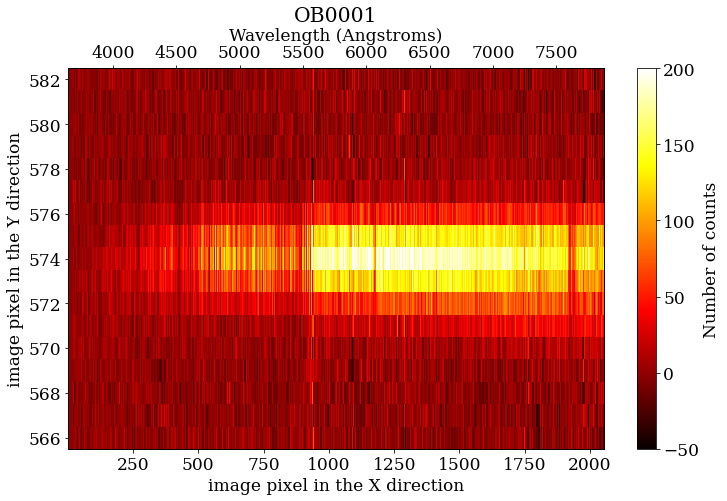

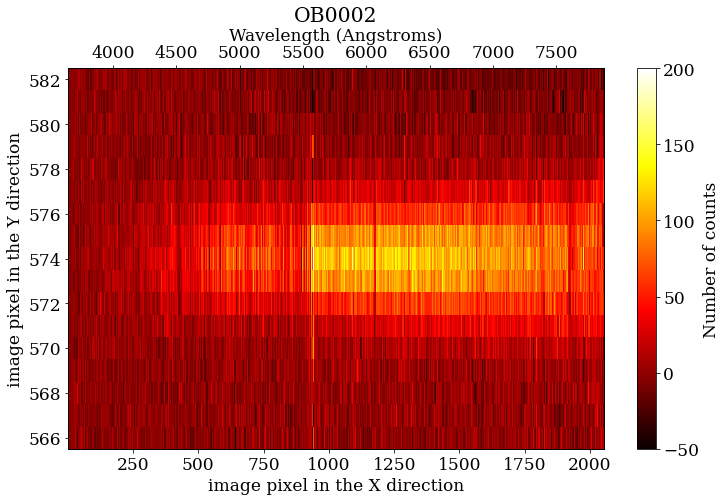

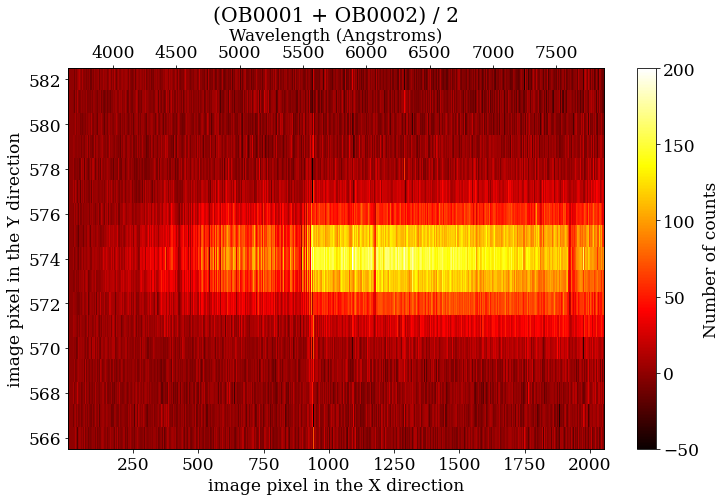

In [66]:
for i, data in enumerate([ob1data, ob2data, obdata]):
    title = ['OB0001', 'OB0002', '(OB0001 + OB0002) / 2']
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 7))
    delta_scans=8
    jimshow(data, ax=ax, vmin=-50, vmax=200, title=title[i],
            image_bbox=(1, naxis1, 574-delta_scans, 574+delta_scans), 
            cbar_orientation='vertical',
            crpix1=crpix1, crval1=crval1, cdelt1=cdelt1, ctype1=ctype1)

In [67]:
# extract the 1D spectrum and scale to ADU/s

ns1 = 570
ns2 = 576
exptime = 1200
spdata = np.sum(obdata[ns1:(ns2+1), :], axis=0) / exptime


To carry out the flux calibration of the target spectrum, we observed the spectro-photometric standard star GD153 with the same instrument setup (OSIRIS R1000B long-slit mode).
We read the file derived in '1_Response_curve_OSIRIS.ipynb' which contains the wavelength, the response curve, and the continuum boundaries derived with **boundfit**. 


The fit to the stellar continuum corresponds with the variable **cont1** (orange line, left panel).

The response curve is **cont2** (blue line, left panel)

The telluric correction (**telcorr**) is computed as **cont2** / **cont1** (right panel). The different colors stand for different values of the correction factor responsible to adjust the depth of the absorptions. 

The correction of this depth is very important when the target and the standard star are observed at different airmasses. For this task, we used the following equation:

${\rm SP}_{\rm calibrated} = \frac{\rm SP}{cont1 \cdot (1 + ({\rm telcorr} - 1) \cdot {\rm Factor})}$

where SP$_{\rm calibrated}$ is the calibrated target spectrum in erg s$^{-1}$ cm$^{-2}$ Å, SP is the original target spectrum in ADUs/s, cont1 is the fit to the stellar continuum in the response curve, telcorr is defined as telcorr = $\frac{\rm cont2}{\rm cont1}$, and the Factor parameter is a constant to adjust the depth of the absorptions.


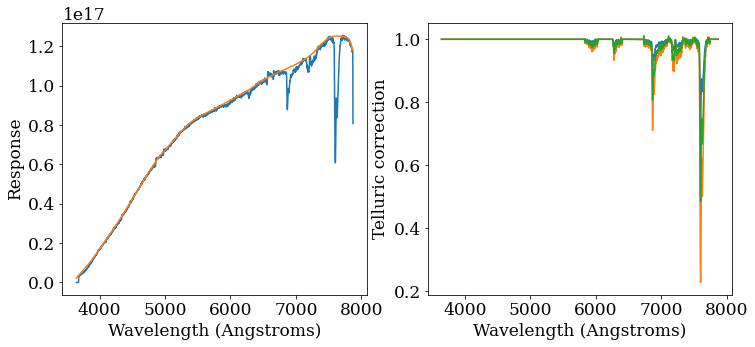

In [69]:
resptable = np.genfromtxt('response.txt')
response = resptable[:, 1]
cont1 = resptable[:, 2]
cont2 = resptable[:, 3]

telcorr = cont2/cont1

fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
ax1, ax2 = axarr
ax1.plot(wave, response)
ax1.plot(wave, cont1)
ax1.set_xlabel('Wavelength (Angstroms)')
ax1.set_ylabel('Response')
ax2.plot(wave, 1+(telcorr-1)*0.5)
ax2.plot(wave, 1+(telcorr-1)*1.5)
ax2.plot(wave, telcorr)
ax2.set_xlabel('Wavelength (Angstroms)')
ax2.set_ylabel('Telluric correction')
plt.show()

Since the target was observed at a higher airmass (airmass ∼ 1.2) than the standard star (airmass ∼ 1.0), we ran some tests to properly correct the telluric absorptions. 

We show below some examples of the calibrated spectrum of J1219 with (orange) and without (blue) the telluric correction using different values of the Factor parameter. The panels show a zoom of the spectral region affected by the strongest telluric absorptions. The continuum around the largest absorption, which is located at ∼ 7600  ̊A, was estimated and subtracted to set the spectrum to zero. Then, we computed the area under this absorption for all the spectra (yellow region). In this way, the best correction of the telluric absorptions corresponds with an area similar to zero. 

In [15]:
# Wavelength range of the largest absorption feature

wv1 = 7585
wv2 = 7690


px1 = (wv1 - np.float(crval1))/ np.float(cdelt1)
px2 = (wv2 - np.float(crval1))/ np.float(cdelt1)



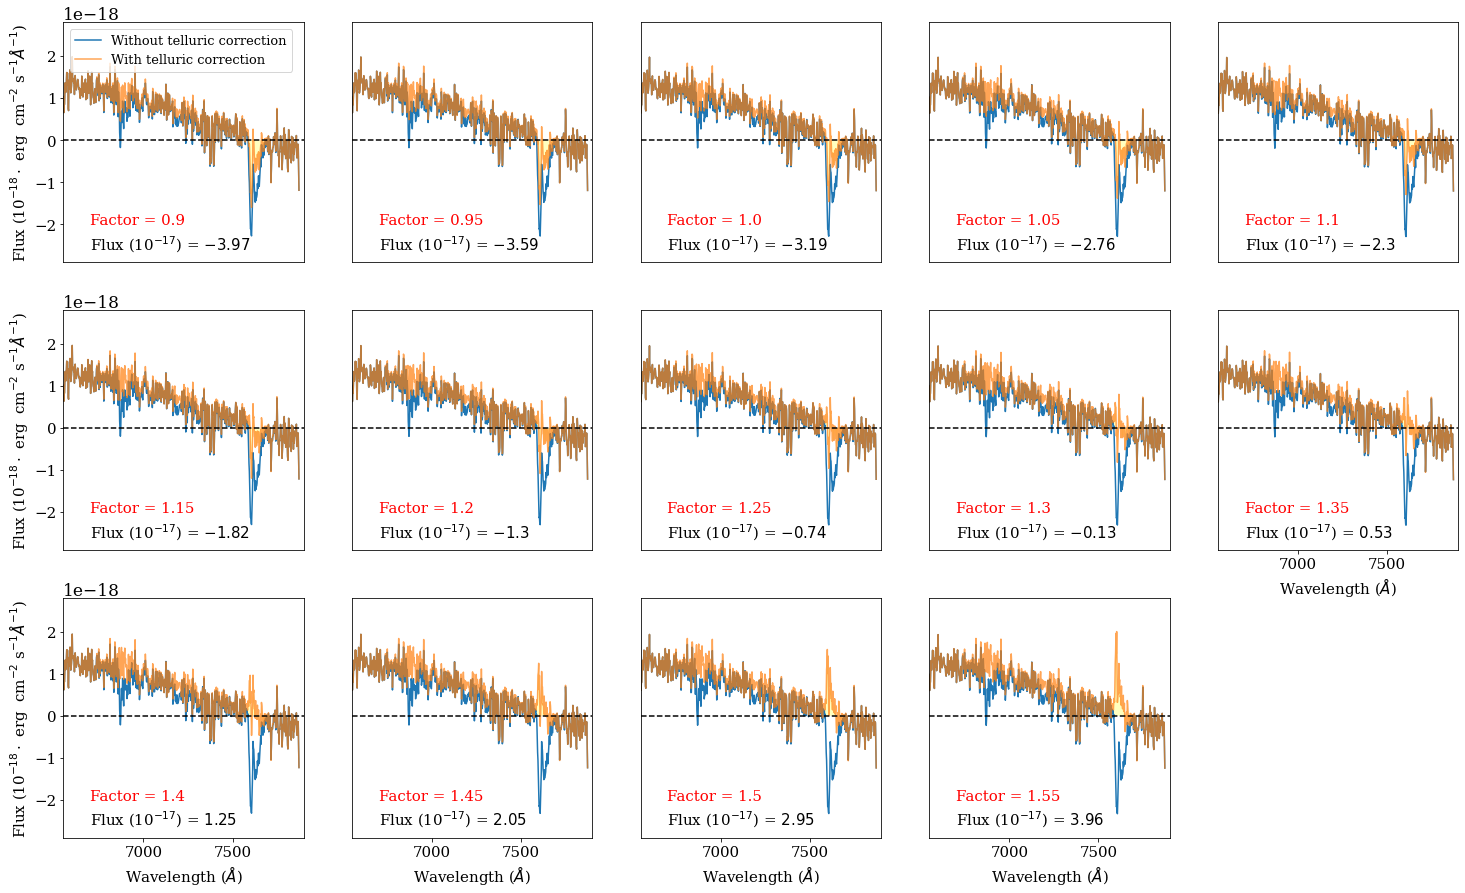

In [16]:
factor = np.arange(0.9,1.6, 0.05)

f = []

plt.figure(figsize = (25,15))
for i in range (1,15):
    plt.subplot(3,5,i)
    
    spcalibrated_ini = spdata/(cont1*(1+(telcorr-1)*factor[i-1]))
    a = (spcalibrated_ini[np.int(px1)] + spcalibrated_ini[np.int(px2)])/2

    sp_final = spcalibrated_ini -a
    pricemin = sp_final[np.int(px1):np.int(px2)].min()
    flux = np.trapz(sp_final[np.int(px1):np.int(px2)],dx= np.float(cdelt1))
    f.append(flux)

    if i==1:
        plt.plot(wave, (spdata/cont1)-a, label='Without telluric correction')
        plt.plot(wave, sp_final, label='With telluric correction', alpha=0.7)
        plt.legend(loc=2,prop={'size': 13})
    else: 
        plt.plot(wave, (spdata/cont1)-a)
        plt.plot(wave, sp_final, alpha=0.7)
    plt.xlabel('Wavelength ($\AA$)', size=15)
    plt.ylabel('Flux (10$^{-18} \cdot$ erg  cm$^{-2}$ s$^{-1} \AA^{-1}$)', size=15)
    
    plt.fill_between(wave[np.int(px1):np.int(px2)], 0, sp_final[np.int(px1):np.int(px2)],
                facecolor="yellow", alpha=0.25) 
    plt.text(6700,-2E-18,'Factor = ' + str(np.round(factor[i-1],2)), size=15,color='red')
    plt.text(6700,-2.6E-18,'Flux (10$^{-17}$) = $' + str(np.round(flux/1E-17,2))+ '$', size=15,color='black')
    plt.ylim([-0.29E-17, 0.28E-17])
    plt.xlim([6550, 7900])
    plt.axhline(0,color='black', linestyle='dashed')
    plt.xticks(size=15)
    plt.yticks(size=15)
    if i ==11:
        continue
    elif i==14 or i ==10 or i==13 or i ==12:
        plt.yticks([])
        plt.ylabel(' ')
    elif i==1 or i==6 or i==11:
        plt.xticks([])
        plt.xlabel(' ')
    else: 
        plt.xticks([])
        plt.xlabel(' ')
        plt.yticks([])
        plt.ylabel(' ')
plt.show()

As shown in the figures, in the case of the optical J1219 data, the airmass was not equal during the observations and with a value of Factor = 1.0 we would not fully correct the absorptions. Furthermore, if the Factor is too high (eg., Factor = 1.5), we would overestimate the correction.

We also represented the flux variation of the largest telluric absorption as a function of the Factor parameter. We used a polynomial of degree 2 to fit the data (red solid line) and obtain the best Factor value to correct our target spectrum.

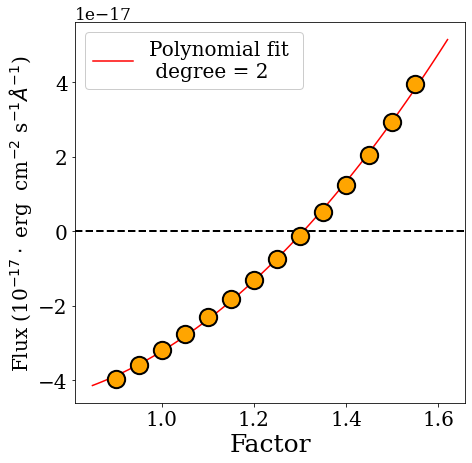

In [17]:
z = np.polyfit(factor,f, 2)
p = np.poly1d(z)


newx = np.arange(0.85,1.63,step = 0.01)

newy = []

for j in range(len(newx)):
    newy.append(p(newx[j]))
    
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))
ax.scatter(factor,f, s=300,edgecolor='black',zorder=2, color='orange', linewidths=2)
ax.set_xlabel('Factor', size=25)
ax.set_ylabel('Flux (10$^{-17} \cdot$ erg  cm$^{-2}$ s$^{-1} \AA^{-1}$)', size=20)
ax.axhline(0,color='black', linestyle='dashed',linewidth=2, zorder=1)
ax.plot(newx,newy,color='red',zorder=1,label='Polynomial fit \n degree = 2')
ax.legend(loc=2, prop={'size': 20, 'family':'serif'},framealpha = 1)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Hence, we found that Factor = 1.3 correctly compensates for the effect of the telluric absorptions, and we applied this correction to our target spectrum. The target spectrum is completely compensated for the strong telluric absorptions located at ∼$6900\overset{\circ}{A}$ and ∼$7600\overset{\circ}{A}$, which proves the power of this method to properly correct for telluric absorptions.

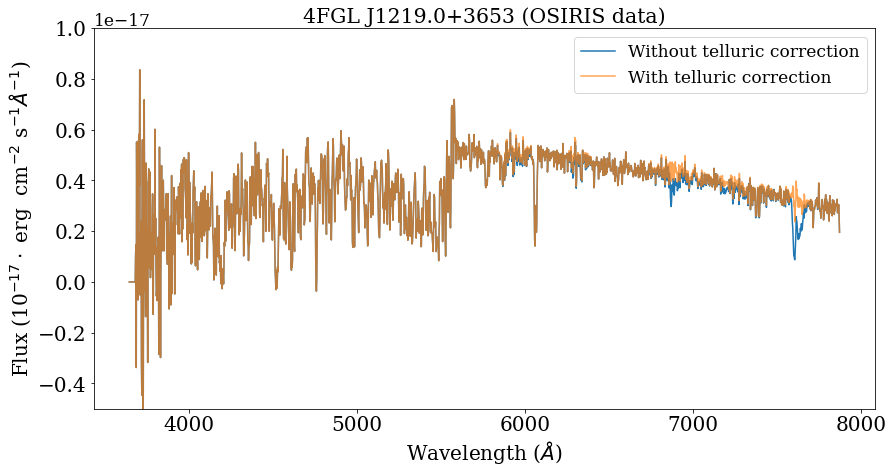

In [18]:
spcalibrated_ini = spdata/(cont1*(1+(telcorr-1)*1.3))


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax.plot(wave, spdata/cont1, label='Without telluric correction')
ax.plot(wave, spcalibrated_ini, label='With telluric correction', alpha=0.7)
ax.set_xlabel('Wavelength ($\AA$)', size=20)
ax.set_ylabel('Flux (10$^{-17} \cdot$ erg  cm$^{-2}$ s$^{-1} \AA^{-1}$)', size=20)
ax.set_title('4FGL J1219.0+3653 (OSIRIS data)')
ax.legend()
ax.set_ylim([-0.5E-17, 1E-17])
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('plots/telluric_correction.pdf',  bbox_inches='tight')
plt.show()


##  <span style="color:blue"> ---> FLUX CORRECTION</span> 

Once the spectrum of our target is flux calibrated, we computed the r' synthetic magnitude using the **synphot** package (see https://synphot.readthedocs.io/en/latest/).

Then, we define the spectrum and the corresponding r' filters in the OSIRIS (from http://www.gtc.iac.es/instruments/osiris/#BroadBand_Imaging) and SDSS (from https://www.sdss.org/instruments/camera/) systems. 


  points: [3685.83608  3696.1482   3708.522744 3712.647592 3716.77244  3718.834864
 3727.08456  3731.209408 3739.459104 3741.521528 3745.646376 3753.896072
 3786.894856 3805.456672 3807.519096 3809.58152  3813.706368 3819.89364
 3830.20576  3881.76636  3892.07848  3898.265752 3914.765144 4189.067536
 4193.192384 4197.317232 4205.566928 4516.992952 4519.055376 4523.180224
 4525.242648 4756.234136 4758.29656 ]
  lookup_table: [-6.25739079e-07 -1.31847431e-07 -9.57482766e-08 -6.15966081e-08
 -5.91729067e-07 -8.34911162e-07 -1.13177495e-06 -6.97614142e-08
 -1.75317406e-09 -2.57825684e-07 -2.00910941e-07 -5.99599973e-07
 -2.43676047e-07 -1.05281872e-07 -7.15856894e-08 -1.40408624e-07
 -1.79285737e-10 -5.47993245e-07 -5.74649917e-07 -2.08158060e-07
 -1.77424085e-07 -8.97418812e-08 -9.37250830e-08 -1.40103776e-08
 -1.26661352e-08 -5.64405059e-08 -1.63753199e-08 -6.72822670e-08
 -6.84793040e-08 -5.58726252e-08 -2.23363842e-09 -2.41138400e-08
 -8.69198712e-08] [synphot.models]


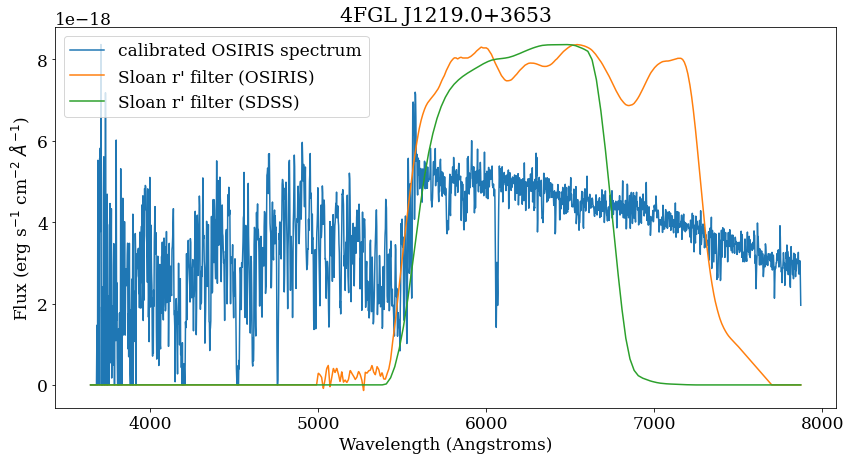

In [23]:
# define spectrum
src_spectrum = SourceSpectrum(Empirical1D, points=wave, lookup_table=spcalibrated_ini*units.FLAM)
# define bandpass corresponding to Sloan r' (from http://www.gtc.iac.es/instruments/osiris/#BroadBand_Imaging)
bp_rmag = SpectralElement.from_file('Sloanr.txt')

# SDSS filter responses from https://www.sdss.org/instruments/camera/
with fits.open('filter_curves_SDSS.fits') as hdul:
    tbl = hdul[3].data
with open('original_r_sdss.txt', 'wt') as f:
    for i in range(len(tbl)):
        f.write('{:e}  {:e}\n'.format(tbl[i][0], tbl[i][1]))

bp_rmag_sdss = SpectralElement.from_file('original_r_sdss.txt')

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax.plot(wave, src_spectrum(wave, flux_unit=units.FLAM), label='calibrated OSIRIS spectrum')
ax.plot(wave, bp_rmag(wave)/max(bp_rmag(wave))*max(spcalibrated_ini), 
        label="Sloan r' filter (OSIRIS)")
ax.plot(wave, bp_rmag_sdss(wave)/max(bp_rmag_sdss(wave))*max(spcalibrated_ini), 
        label="Sloan r' filter (SDSS)")
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
ax.set_title('4FGL J1219.0+3653')
ax.legend()
plt.show()

We compute the r' synthetic magnitude for both the r' bandpass of OSIRIS and SDSS, and the difference magnitude between these two systems.

In [24]:
obs = Observation(src_spectrum, bp_rmag)
rmag_synthetic_osiris = obs.effstim(flux_unit='abmag')
print("Sloan r' magnitude (OSIRIS): {}".format(rmag_synthetic_osiris))
obs = Observation(src_spectrum, bp_rmag_sdss)
rmag_synthetic_sdss = obs.effstim(flux_unit='abmag')
print("Sloan r' magnitude (SDSS)..: {}".format(rmag_synthetic_sdss))
rmag_filter_correction = rmag_synthetic_osiris.value - rmag_synthetic_sdss.value
print("Delta r' magnitude.........: {}".format(rmag_filter_correction))

Sloan r' magnitude (OSIRIS): 21.940341036691077 mag(AB)
Sloan r' magnitude (SDSS)..: 21.960949288239917 mag(AB)
Delta r' magnitude.........: -0.020608251548839718


Furthermore, we decided to refine our flux calibration by computing a flux correction factor to account for light losses due to the seeing being slightly larger than the slit width. For this task, we carried out the photometric calibration of the acquisition image using the available r' SDSS photometric data. 



The r′ OSIRIS acquisition image exhibited hot and cold pixels that could affect the photometric measurements. To fix this, we used the cleanest (see  https://cleanest.readthedocs.io/en/latest/) software ([Cardiel 2020](https://ui.adsabs.harvard.edu/abs/2020ASPC..522..723C/abstract)) to interpolate defective pixels in the region around the J1219 object. In addition, the OSIRIS acquisition images usually have a high noise pattern, and we therefore flatted the background of our image using the nebuliser program that is included in the CASUTools package (see http://casu.ast.cam.ac.uk/surveys-projects/software-release).


We then read this acquisition image, rotated and cropped it, and subtracted the median background value.
Finally, we plot the image and highlight the position of the J1219 source.  

In [25]:
infile = '../preliminary_reduction/0002581313c_skysub_101_101.fits'
with fits.open(infile) as hdul:
    data = hdul[0].data
    
# rotate image
data = np.rot90(data, 3)

# crop image
nx1, nx2, ny1, ny2 = 100, 950, 600, 1400
data = data[ny1:ny2, nx1:nx2]

# subtract median background value
data -= np.median(data)

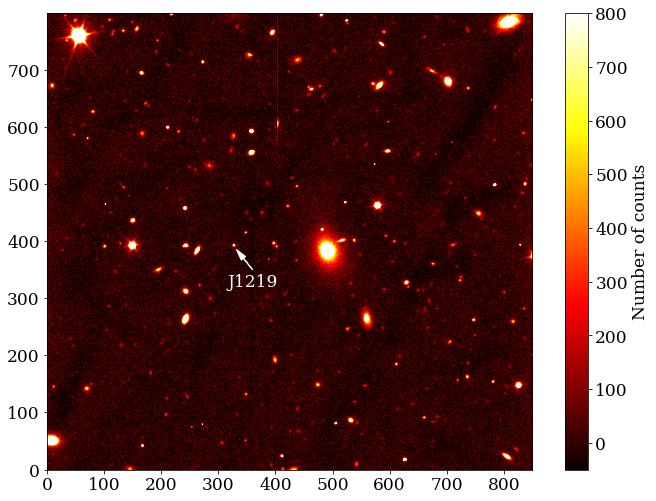

In [27]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(plotwidth, plotwidth*0.7))
im = ax.imshow(data, origin='lower', vmin=-50, vmax=800, cmap='hot', aspect='equal')
plt.colorbar(im, orientation='vertical', ax=ax, label='Number of counts')
ax.arrow(360, 350, -16, 20, color='white', head_width=10, head_length=20)
ax.text(360, 320, 'J1219', ha='center', color='white')
plt.show()

Here we follow the steps given in https://photutils.readthedocs.io/en/stable/getting_started.html and in https://photutils.readthedocs.io/en/stable/aperture.html


First, we employed the 'DAOStarFinder' function of **photutils** to detect peaks above a certain threshold in the acquisition image. We selected only the brightest sources and performed aperture photometry. 

In [29]:
bkg_sigma = mad_std(data)
daofind = DAOStarFinder(fwhm=4., threshold=3.*bkg_sigma) 
sources = daofind(data)
for col in sources.colnames:
    sources[col].info.format = '%.8g'   # for consistent table output
    
print(sources)


 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
--- --------- --------- ---------- ... --- --------- --------- ------------
  1 144.51969 1.5701441 0.43146828 ...   0 670.92798 2.9141507     -1.16128
  2 412.02498 1.4615703 0.28449384 ...   0 440.48315 2.7659042   -1.1045928
  3 619.14972  4.285563 0.32749588 ...   0 75.526611 1.0680111 -0.071439429
  4 574.57287 5.1497009 0.52133625 ...   0  99.54248 1.1373703  -0.13975471
  5 154.78389 8.0431222 0.83541076 ...   0 159.09375 1.0188655 -0.020292138
  6 487.15379 8.9960713 0.64892455 ...   0 102.90234 1.0810127 -0.084577023
  7 2.5616061 10.697259  0.6324412 ...   0 170.62793 1.0840915 -0.087664827
  8 392.21402 9.0272976  0.2161519 ...   0 180.93481 1.6117216   -0.5182251
  9 825.78727 10.777044 0.29534561 ...   0 132.68384 1.3434226   -0.3205316
 10  360.1644 12.154287 0.46518503 ...   0 105.76611 1.1450871  -0.14709635
...       ...       ...        ... ... ...       ...       ...          ...
551 270.3797

In order to select only the brightest objects, we plot the number of sources as a function of the peak signal:

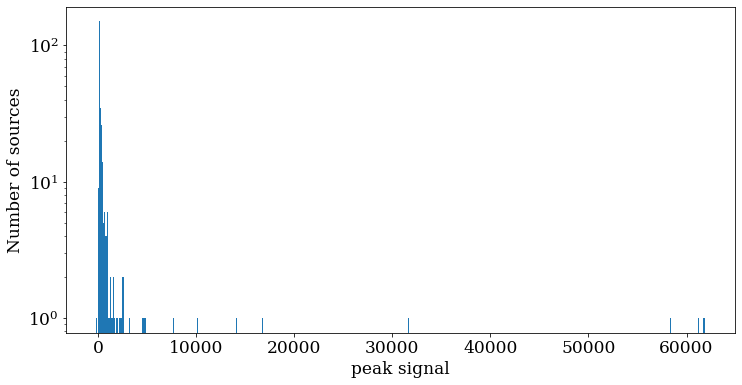

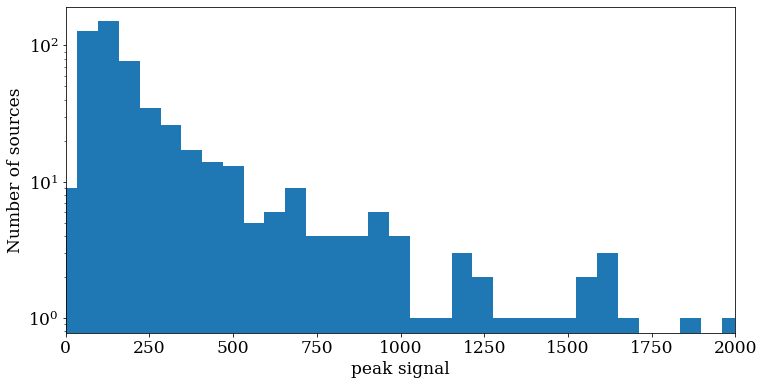

In [30]:
for iplot in range(2):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(plotwidth, plotwidth/2))
    ax.hist(sources['peak'], bins=1000)
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('peak signal')
    ax.set_ylabel('Number of sources')
    if iplot == 1:
        ax.set_xlim([0,2000])

In [31]:
# select only the brightest objects
sources = sources[sources['peak'] > 500]
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,144.51969,1.5701441,0.43146828,-0.36791986,-0.87205198,25,0,670.92798,2.9141507,-1.16128
12,625.28616,17.936857,0.57033249,-0.088908428,-0.17015619,25,0,9726.4824,55.092641,-4.352734
16,804.13265,23.355102,0.46210227,-0.66871763,-0.34244956,25,0,2503.344,8.9015998,-2.3736702
18,410.47934,24.33501,0.41801281,-0.54287781,-0.40941338,25,0,1275.4338,6.2810972,-1.9950888
26,166.51984,42.213041,0.49045161,-0.066547042,0.038518895,25,0,1983.4612,11.266906,-2.6295116
27,7.2665258,51.347152,0.45475122,-0.13956011,-0.26229848,25,0,16786.125,56.684892,-4.3836683
28,346.87186,51.504383,0.62675169,0.75548334,0.18827295,25,0,522.34253,2.5332755,-1.0092061
43,504.42027,81.555161,0.52876828,-0.14596854,-0.070733009,25,0,2147.0803,12.326915,-2.727136
46,530.24307,86.791936,0.39496872,-0.20239775,-0.25124139,25,0,2245.0554,10.03096,-2.5033562


For the circular aperture photometry, we decided to use apertures with a radius ~ 2* FWHM ~ 5 pixels.
The FWHM value was obtained by fitting a centroid to the stars present in the acquisition image with the **xnirspec** software (https://github.com/nicocardiel/xnirspec) developed by N. Cardiel.

In [32]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

# sigma of centroid fitting to stars: ~1.1 pixels -> FWHM = 1.1*2.35 = 2.585 pixels
# we are using apertures with radius ~ 2*FWHM ~ 5 pixels
apertures = CircularAperture(positions, r=5.) 
annulus_apertures = CircularAnnulus(positions, r_in=10, r_out=15)
annulus_masks = annulus_apertures.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)

phot = aperture_photometry(data, apertures) 
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * apertures.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
for col in phot.colnames:
    phot[col].info.format = '%.8g'  # for consistent table output
phot


id,xcenter,ycenter,aperture_sum,annulus_median,aper_bkg,aper_sum_bkgsub
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,144.51969,1.5701441,19636.679,0,0,19636.679
2,625.28616,17.936857,83521.254,4.8413086,380.23549,83141.018
3,804.13265,23.355102,73017.755,24.692505,1939.3448,71078.411
4,410.47934,24.33501,21690.893,-2.5715332,-201.96775,21892.86
5,166.51984,42.213041,22950.527,3.6616211,287.58305,22662.944
6,7.2665258,51.347152,522013.65,175.93994,13818.291,508195.36
7,346.87186,51.504383,5107.0248,-10.018555,-786.85545,5893.8803
8,504.42027,81.555161,19720.372,-16.451538,-1292.1008,21012.473


Object #13 is likely saturated
Object #40 is likely saturated
Object #53 is likely saturated
Object #87 is likely saturated


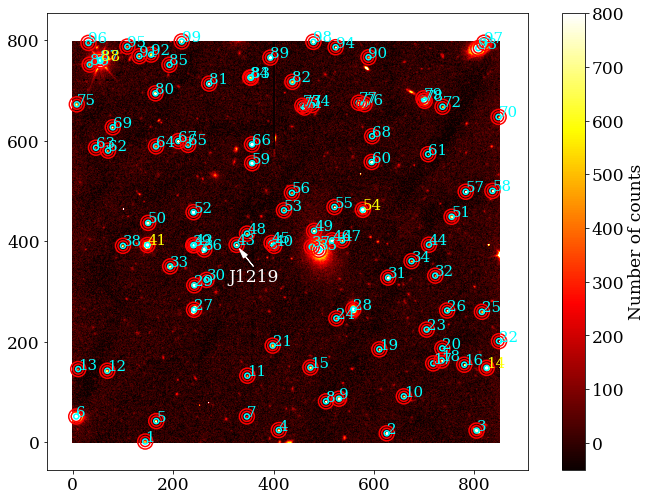

In [34]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(plotwidth, plotwidth*0.7))
im = ax.imshow(data, origin='lower', vmin=-50, vmax=800, cmap='hot', aspect='equal')
fig.colorbar(im, orientation='vertical', ax=ax, label='Number of counts')
apertures.plot(color='cyan', lw=1.5, alpha=1.0)
annulus_apertures.plot(color='red', lw=1.5, alpha=1.0)
for i in range(len(phot)):
    row = phot[i]
    if sources[i]['peak'] > 60000:
        textcolor = 'yellow'
        print('Object #{} is likely saturated'.format(i))
    else:
        textcolor = 'cyan'
    ax.text(row['xcenter'].value, row['ycenter'].value, str(i+1), color=textcolor, fontsize=15)
ax.arrow(360, 350, -16, 20, color='white', head_width=10, head_length=20)
ax.text(360, 320, 'J1219', ha='center', color='white')
plt.show()

We then made use of the SDSS Sky Server (http://skyserver.sdss.org/dr16/en/tools/chart/navi.aspx) to identify these sources and obtain their r' SDSS magnitude (for those available). The list of objects is stored in ``table_acquisition_sdss.txt``.



In [35]:
df_sdss_objects = pd.read_csv('table_acquisition_sdss.txt', sep='\s+', header=0, comment='#')

# insert empty column to store result
nrows = len(df_sdss_objects)
emptycolumn = np.array([np.nan]*nrows)

prevcol = df_sdss_objects.columns.get_loc('r_mag')
df_sdss_objects.insert(prevcol+1, 'r_mag_BLLac', emptycolumn)
df_sdss_objects

,object_id,ra,dec,type,r_mag,r_mag_BLLac
0,2,184.77528,36.94067,star,20.25,NaN
1,4,184.79270,36.93420,galaxy,21.65,NaN
2,5,184.81300,36.92760,galaxy,21.81,NaN
3,7,184.79893,36.93395,star,23.84,NaN
4,8,184.78743,36.94093,star,22.14,NaN
...,...,...,...,...,...,...
47,81,184.83169,36.97390,star,21.77,NaN
48,82,184.81859,36.97947,galaxy,20.83,NaN
49,89,184.82412,36.98113,galaxy,20.12,NaN
50,90,184.80863,36.98760,galaxy,21.88,NaN


Thanks to the data from neighboring sources (``table_acquisition_sdss.txt``), we could estimate the r' magnitude of our J1219 target using the Pogson law.

Furthermore, since we have used the r' SDSS magnitudes of the sources present in the acquisition image, we applied the filter correction factor previously computed (rmag_filter_correction, $\Delta {\rm r'}_{{\rm OSIRIS} - {\rm SDSS}}$) to obtain the estimations of the r' OSIRIS magnitude of the J1219 object.

In [36]:
flux1 = phot[phot['id'] == 43]['aper_sum_bkgsub'][0]

for i in range(nrows):
    object_id = df_sdss_objects.at[i, 'object_id']
    flux2 = phot[phot['id'] == object_id]['aper_sum_bkgsub'][0]
    df_sdss_objects.at[i, 'r_mag_BLLac'] = df_sdss_objects.at[i, 'r_mag'] - 2.5 * np.log10(flux1/flux2)
    # apply correction: r' (OSIRIS) -> r' (SDSS)
    df_sdss_objects.at[i, 'r_mag_BLLac'] += rmag_filter_correction
    
df_sdss_objects

,object_id,ra,dec,type,r_mag,r_mag_BLLac
0,2,184.77528,36.94067,star,20.25,21.570641
1,4,184.79270,36.93420,galaxy,21.65,21.521859
2,5,184.81300,36.92760,galaxy,21.81,21.719393
3,7,184.79893,36.93395,star,23.84,22.287106
4,8,184.78743,36.94093,star,22.14,21.967295
...,...,...,...,...,...,...
47,81,184.83169,36.97390,star,21.77,21.654995
48,82,184.81859,36.97947,galaxy,20.83,20.963956
49,89,184.82412,36.98113,galaxy,20.12,21.502861
50,90,184.80863,36.98760,galaxy,21.88,21.311972


We decided to use only the stars to derive the r' magnitude of the J1219 object.

We then plot the resulting SDSS r' magnitudes of the J1219 object using the objects in its neighborhood as a reference for the photometric calibration. Stars are depicted with blue dots and galaxies with orange plus symbols. Likely saturated stars are marked with red crosses. The Sloan r′ magnitude of the J1219 object is marked with a green square. The red dashed line depicts the median r′ magnitude of J1219 computed using only the stars in the calibration. The black dashed line indicates the synthetic r′ magnitude of J1219 computed from the OSIRIS spectrum.

Median r' mag: 21.635601782581666
Sigmag r' mag: 0.09123944916360024
Sigmag/sqrt(npoints): 0.023557924475184133


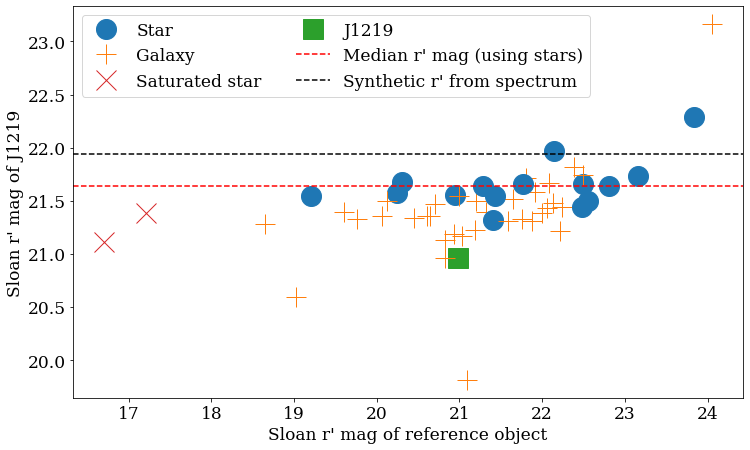

In [38]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(plotwidth, plotwidth*3/5))
id_saturated = [14, 41, 54, 88]
label_used = []
useful_values = []
for i in range(nrows):
    object_id = df_sdss_objects.at[i, 'object_id']
    r_mag = df_sdss_objects.at[i, 'r_mag']
    r_mag_BLLac = df_sdss_objects.at[i, 'r_mag_BLLac']
    objtype = df_sdss_objects.at[i, 'type']
    if object_id == 43:
        marker = 's'
        color = 'C2'
        label = 'J1219'
    elif object_id in id_saturated:
        marker = 'x'
        color = 'C3'
        label = 'Saturated star'
    else:
        if objtype == 'star':
            marker = 'o'
            color = 'C0'
            label = 'Star'
            useful_values.append(r_mag_BLLac)
        else:
            marker = '+'
            color = 'C1'
            label = 'Galaxy'

    if label not in label_used:
        label_used.append(label)
    else:
        label = None
    ax.plot(r_mag, r_mag_BLLac, marker=marker, color=color, markersize=20, label=label, linestyle='')
ax.set_xlabel("Sloan r' mag of reference object")
ax.set_ylabel("Sloan r' mag of J1219")
median_rmag = np.median(useful_values)
sigmag_rmag = robust_std(useful_values)
ax.axhline(median_rmag, label="Median r' mag (using stars)", color='red', linestyle='dashed')
ax.axhline(rmag_synthetic_osiris.value, label="Synthetic r' from spectrum", color='black', linestyle='dashed')
ax.legend(ncol=2)
plt.savefig('plots/photometry_acquisition.pdf',  bbox_inches='tight')


print("Median r' mag: {}".format(median_rmag))
print("Sigmag r' mag: {}".format(sigmag_rmag))
print("Sigmag/sqrt(npoints): {}".format(sigmag_rmag/np.sqrt(len(useful_values))))

Finally, the median of these values (${\rm r'}_{{\rm median}}$) and the synthetic r' magnitude obtained from the OSIRIS spectra (${\rm r'}_{{\rm synthetic}}$) were used to compute the flux correction factor as $10^{-0.4 \cdot ({\rm r'}_{{\rm median}} - {\rm r'}_{{\rm synthetic}})}$, which gave us a value $\sim$~1.3.

Even if the flux correction is not severe, we took into account the possible light losses and the flux of our target spectrum was corrected by this factor.

In [43]:
flux_correction_factor = 10**(-0.4*(median_rmag-rmag_synthetic_osiris.value))
print('Flux correction factor: {}'.format(flux_correction_factor))

Flux correction factor: 1.3240235250279737


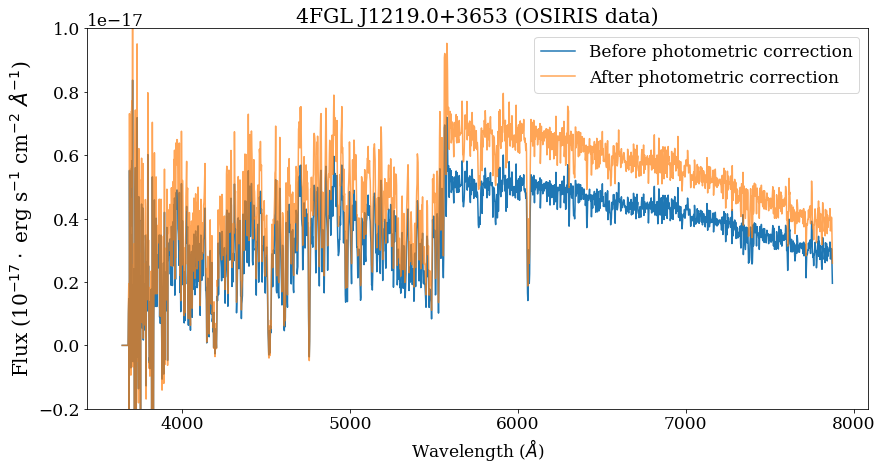

In [51]:
spcalibrated = flux_correction_factor * spcalibrated_ini

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax.plot(wave, spcalibrated_ini, label='Before photometric correction')
ax.plot(wave, spcalibrated, label='After photometric correction', alpha=0.7)
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Flux (10$^{-17} \cdot$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=20)
ax.set_title('4FGL J1219.0+3653 (OSIRIS data)')
#ax.set_xlim([20100, 23900])
ax.set_ylim([-0.2E-17, 1E-17])
ax.legend()
plt.savefig('plots/photometric_correction.pdf',  bbox_inches='tight')

##  <span style="color:blue"> ---> GALACTIC EXTINCTION CORRECTION</span> 

For the final calibration, we took into account the interstellar dust extinction, i.e, the effect of the dust along the line of sight that removes part of the flux by absorbing or scattering photons.

The correction is computed as explained in the tutorial http://learn.astropy.org/rst-tutorials/color-excess.html?highlight=filtertutorials


We corrected our J1219 spectrum for Galactic extinction by using the 'dust_extinction' Astropy package (https://dust-extinction.readthedocs.io/en/stable/\#) .

The color excess $E(B-V) = 0.0151$ for this target was retrieved from the NASA/IPAC Infrared Science Archive (https://irsa.ipac.caltech.edu/applications/DUST/) with coordinates: $\alpha =$12h 19m 15.41000s, $\beta =$+36d 57m 18.5000 (J2000 Equinox). 


We used the estimates of Galactic dust extinction from [Schlafly & Finkbeiner (2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...737..103S/abstract) and adopted the [Fitzpatrick
(1999)](https://ui.adsabs.harvard.edu/abs/1999PASP..111...63F/abstract) model for R$_{V}$ = 3.1 (blue line).

The derived correction factor (orange line) has values in the range [1.02 $-$ 1.07].

                This has been deprecated in v4.0 and support will be removed in v4.1.
                Starting with v4.0 classes must define a class attribute ``n_inputs``.
                Please consult the documentation for details.
                 [astropy.modeling.core]
                This has been deprecated in v4.0 and support will be removed in v4.1.
                Starting with v4.0 classes must define a class attribute ``n_inputs``.
                Please consult the documentation for details.
                 [astropy.modeling.core]
/Users/criscabe/opt/anaconda3/envs/py36/lib/python3.6/site-packages/dust_extinction/helpers.py:28: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn("x has no units, assuming x units are inverse microns")


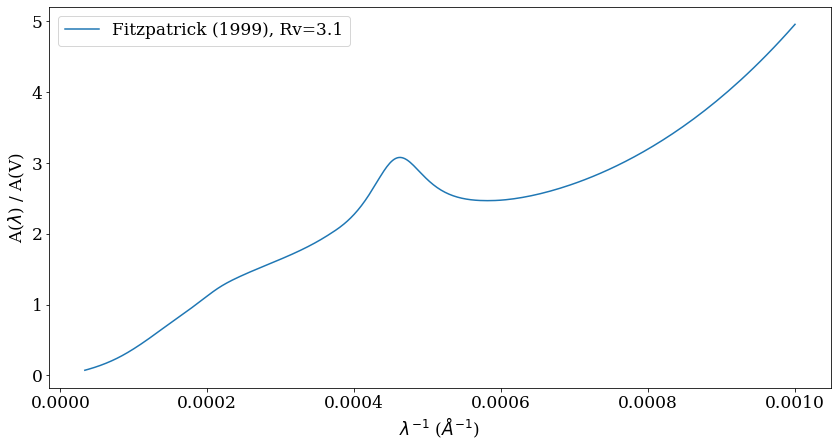

In [45]:
# Create wavelengths array
wav = np.arange(1000, 30000, 10)*u.angstrom
ext = F99(Rv=3.1)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax.plot(1/wav, ext(wav), color='C0', label='Fitzpatrick (1999), Rv=3.1')
ax.set_xlabel('$\lambda^{-1}$ ($\AA^{-1}$)')
ax.set_ylabel('A($\lambda$) / A(V)')
ax.legend(loc=2)

                This has been deprecated in v4.0 and support will be removed in v4.1.
                Starting with v4.0 classes must define a class attribute ``n_inputs``.
                Please consult the documentation for details.
                 [astropy.modeling.core]
/Users/criscabe/opt/anaconda3/envs/py36/lib/python3.6/site-packages/dust_extinction/helpers.py:28: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn("x has no units, assuming x units are inverse microns")
                This has been deprecated in v4.0 and support will be removed in v4.1.
                Starting with v4.0 classes must define a class attribute ``n_inputs``.
                Please consult the documentation for details.
                 [astropy.modeling.core]
/Users/criscabe/opt/anaconda3/envs/py36/lib/python3.6/site-packages/dust_extinction/helpers.py:28: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn("x has no units, assuming x un

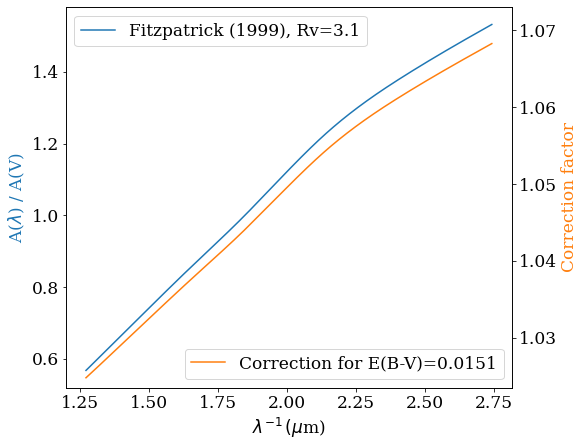

In [46]:
wave_units = (1/wave)*(10000)  # inverse wavelength in microns

ext = F99(Rv=3.1)
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(8, 7))
ax1.plot(wave_units, ext(wave_units), color='C0', label='Fitzpatrick (1999), Rv=3.1')
ax1.set_xlabel('$\lambda^{-1} \,(\mu$m)')
ax1.set_ylabel('A($\lambda$) / A(V)', color='C0')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(wave_units, 1/ext.extinguish(wave_units, Ebv=0.0151), color='C1', 
         label='Correction for E(B-V)=0.0151')
ax2.set_ylabel('Correction factor', color='C1')
ax2.set_ylim(1.0235,1.073)
ax2.legend(loc=4)
plt.savefig('plots/curve_extinction.pdf',  bbox_inches='tight')

We applied this correction factor to our target spectrum even if the effect is small. 


/Users/criscabe/opt/anaconda3/envs/py36/lib/python3.6/site-packages/dust_extinction/helpers.py:28: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn("x has no units, assuming x units are inverse microns")
                This has been deprecated in v4.0 and support will be removed in v4.1.
                Starting with v4.0 classes must define a class attribute ``n_inputs``.
                Please consult the documentation for details.
                 [astropy.modeling.core]


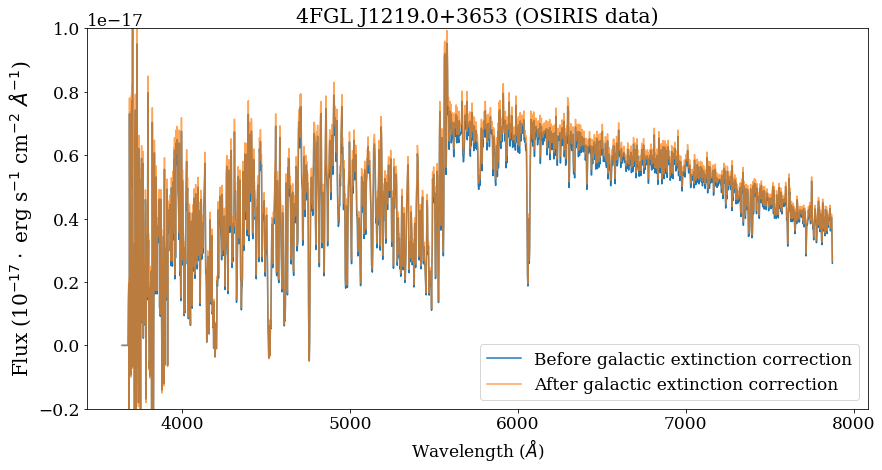

In [50]:
# apply galactic extinction correction
spcalibrated_ext = spcalibrated / ext.extinguish(wave_units, Ebv=0.0151)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax.plot(wave, spcalibrated, color='C0', label='Before galactic extinction correction')
ax.plot(wave, spcalibrated_ext, color='C1', label='After galactic extinction correction',alpha=0.7)
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Flux (10$^{-17} \cdot$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=20)
ax.set_title('4FGL J1219.0+3653 (OSIRIS data)')
ax.set_ylim([-0.2E-17, 1E-17])
ax.legend()
plt.savefig('plots/extinction_correction.pdf',  bbox_inches='tight')

##  <span style="color:blue"> ---> S/N estimation and comparison with SLOAN spectrum</span>

The Sloan spectrum of the J1219 object was obtained from https://dr16.sdss.org/optical/spectrum/view?id=401130&plate=4701&mjd=55709&fiberid=88

In [49]:
with fits.open('spec-4701-55709-0088.fits', mode='readonly') as hdul:
    sdss_header = hdul[0].header
    sdss_tbl = hdul[1].data
# center wavelength (log10) or first pixel
coeff0 = sdss_header['COEFF0']
# Log10 dispersion per pixel
coeff1 = sdss_header['COEFF1']
# BUNIT for flux calibration
bunit = float(sdss_header['BUNIT'].split()[0])
print('Bunit: {}'.format(bunit))

# naxis1
naxis1_sdss = sdss_tbl.shape[0]

sdss_table = Table(sdss_tbl)

wave_sdss = np.array(sdss_table['LOGLAM'])
wave_sdss = 10 ** (coeff0 + np.arange(naxis1_sdss) * coeff1)
sp_sdss = np.array(sdss_table['FLUX']) * bunit


Bunit: 1e-17


We compared our OSIRIS spectrum with the SDSS spectrum taken on 2011 May 28 and the continuum flux level was found to be lower by a factor of ∼3 during GTC observations. 

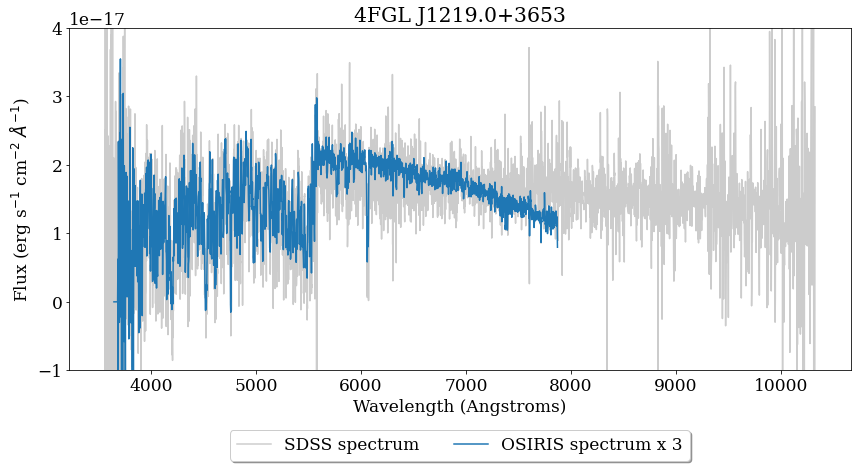

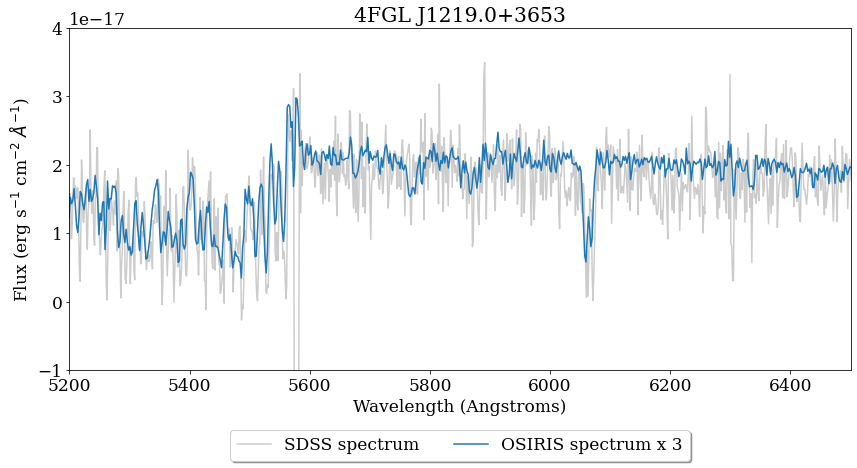

In [52]:
for i in range(2):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
    ax.plot(wave_sdss, sp_sdss, 'k-', alpha=0.2, label='SDSS spectrum')
    ax.plot(wave, 3*spcalibrated_ext, label='OSIRIS spectrum x 3', color='C0', alpha=1.0)
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
    ax.set_title('4FGL J1219.0+3653')
    ax.set_ylim([-1E-17, 4E-17])
    # legend
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)
    if i == 1:
        ax.set_xlim([5200, 6500])

The dispersion (angstrom/pixel) is constant in the OSIRIS spectrum but changes with wavelength for the SDSS spectrum:

In [54]:
# OSIRIS
np.round(wave[1:]-wave[:-1], 4)

array([2.0624, 2.0624, 2.0624, ..., 2.0624, 2.0624, 2.0624])

In [55]:
# SDSS
np.round(wave_sdss[1:]-wave_sdss[:-1], 4)

array([0.8193, 0.8195, 0.8197, ..., 2.3767, 2.3772, 2.3777])

In order to take into account the different sampling in both spectra, we are going to compute the signal-to-noise ratio per angstrom. For that purpose, we use Eq. (42) from [Cardiel et al (1998)](https://ui.adsabs.harvard.edu/abs/1998A%26AS..127..597C/abstract), with $N=1$:

$${\rm SN}_{\unicode{x212B}} = \displaystyle\frac{{\rm SN}_{\rm pixel}}{\sqrt{{\rm dispersion}}}$$

The ${\rm SN}_{\rm pixel}$ will be computed using the method described by [Stoehr et al. (2008)](https://ui.adsabs.harvard.edu/abs/2008ASPC..394..505S/abstract) (see code in http://www.stecf.org/software/ASTROsoft/DER_SNR/der_snr.py).

In [56]:
# compute SNR per Angstrom
def snra_spectrum(w, sp, window):
    npix = len(sp)
    snra = np.zeros(npix, dtype=float)

    for i in range(npix):
        i1 = int(i - window/2)
        if i1 < 0:
            i1 = 0
        i2 = int(i + window/2)
        if i2 > npix:
            i2 = npix
        snr = der_snr(sp[i1:i2])
        if i == 0:
            disp = w[1]-w[0]
        elif i == npix-1:
            disp = w[npix-1]-w[npix-2]
        else:
            disp = (w[i+1]-w[i-1])/2
        snra[i] = snr/np.sqrt(disp)  
    return snra

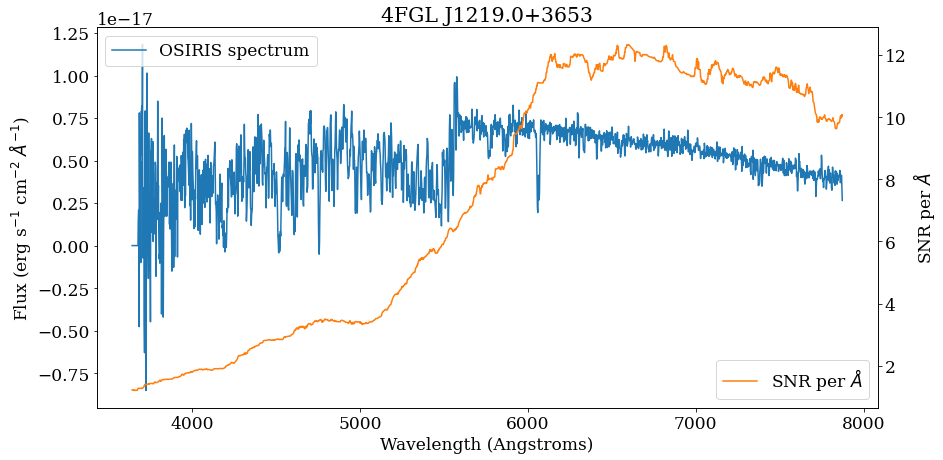

In [60]:
snra_osiris = snra_spectrum(wave, spcalibrated_ext, window=500)
    
        
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax1.plot(wave, spcalibrated_ext, label='OSIRIS spectrum', color='C0', alpha=1.0)
ax1.set_xlabel('Wavelength (Angstroms)')
ax1.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
ax1.set_title('4FGL J1219.0+3653')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(wave, snra_osiris, label='SNR per $\AA$', color='C1', alpha=1.0)
ax2.set_ylabel('SNR per $\AA$')
ax2.legend(loc=4)
plt.show()

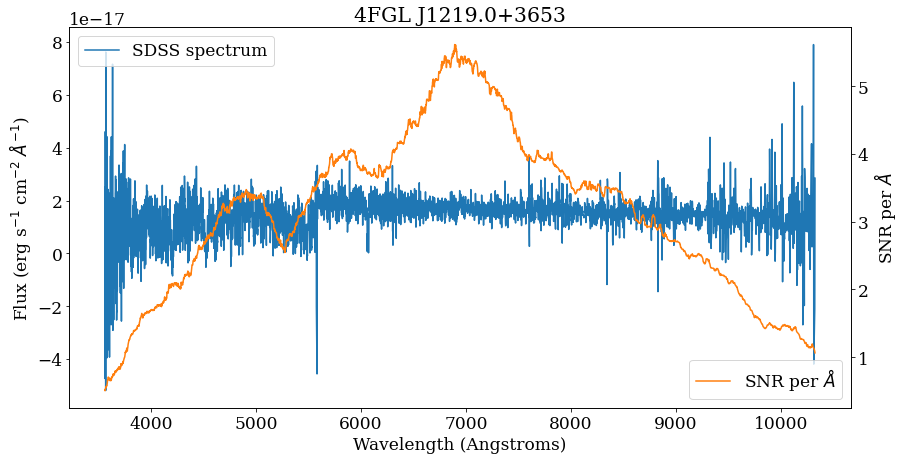

In [61]:
snra_sdss = snra_spectrum(wave_sdss, sp_sdss, window=500)
    
        
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax1.plot(wave_sdss, sp_sdss, label='SDSS spectrum', color='C0', alpha=1.0)
ax1.set_xlabel('Wavelength (Angstroms)')
ax1.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
ax1.set_title('4FGL J1219.0+3653')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(wave_sdss, snra_sdss, label='SNR per $\AA$', color='C1', alpha=1.0)
ax2.set_ylabel('SNR per $\AA$')
ax2.legend(loc=4)
plt.show()

Comparison of OSIRIS and SDSS spectra:

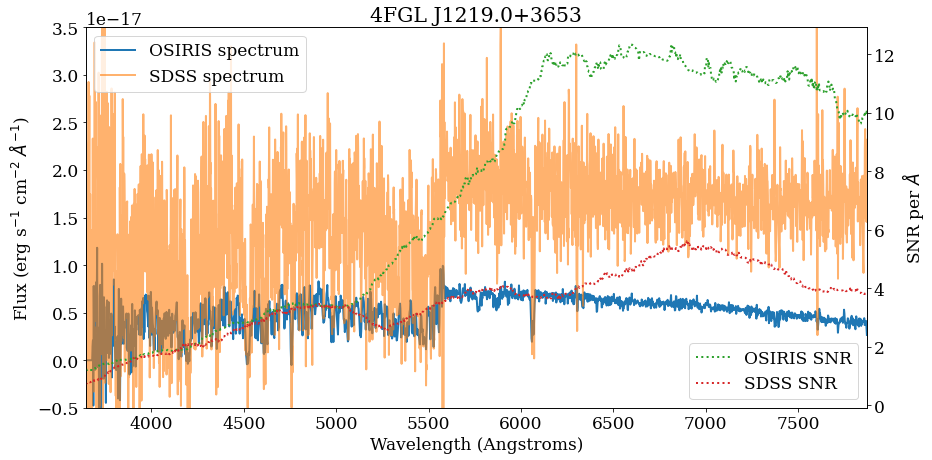

In [62]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax1.plot(wave, spcalibrated_ext, label='OSIRIS spectrum', color='C0', lw=2, alpha=1.0)
ax1.plot(wave_sdss, sp_sdss, label='SDSS spectrum', color='C1', lw=2, alpha=0.6)
ax1.set_xlabel('Wavelength (Angstroms)')
ax1.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
ax1.set_title('4FGL J1219.0+3653')
ax1.legend(loc=2)
ax1.set_xlim([min(wave), max(wave)])
ax1.set_ylim([-0.5E-17, 3.5E-17])
ax2 = ax1.twinx()
ax2.plot(wave, snra_osiris, label='OSIRIS SNR', color='C2', linestyle='dotted', lw=2)
ax2.plot(wave_sdss, snra_sdss, label='SDSS SNR', color='C3', linestyle='dotted', lw=2)
ax2.set_ylabel('SNR per $\AA$')
ax2.legend(loc=4)
plt.show()

The S/N of our final OSIRIS spectrum is ∼3 times higher than the only available SDSS spectrum of J1219. Notwithstanding, no emission line was detected in the optical spectrum, which confirmed the J1219 object as the first BL Lac at z > 3.